# Maximum Likelihood Estimation

We will apply the maximum likelihood estimation to try to predict the angles theta and phi from the bloch sphere. First we will see for pure states, then for mixed states what MLE can bring to Quantum State Tomography.

In [132]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import matplotlib.pyplot as plt

## 1. Pure states

A pure state is a quantum state that holds the maximum possible information about a system.  
It can be written as a single vector, not a mix of several states.

For a qubit, a pure state looks like:
|ψ⟩ = α|0⟩ + β|1⟩
with |α|² + |β|² = 1.

The qubit of a pure state is normalized, meaning it touches the border of the Bloch sphere.

In [133]:
df = pd.read_csv("../../data/qst_mle_dataset_purestates.csv")
N_SHOTS = 100  # For each X, Y, Z basis
TOTAL_SHOTS = 300
df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal
0,0.92,-0.18,-0.28,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920
1,-0.56,-0.58,0.06,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270
2,-0.58,0.04,-0.68,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728
3,-0.36,0.46,0.56,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887
4,0.92,-0.06,-0.52,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747


### 1.1. Data visualization

Let's take a first look at our dataset.

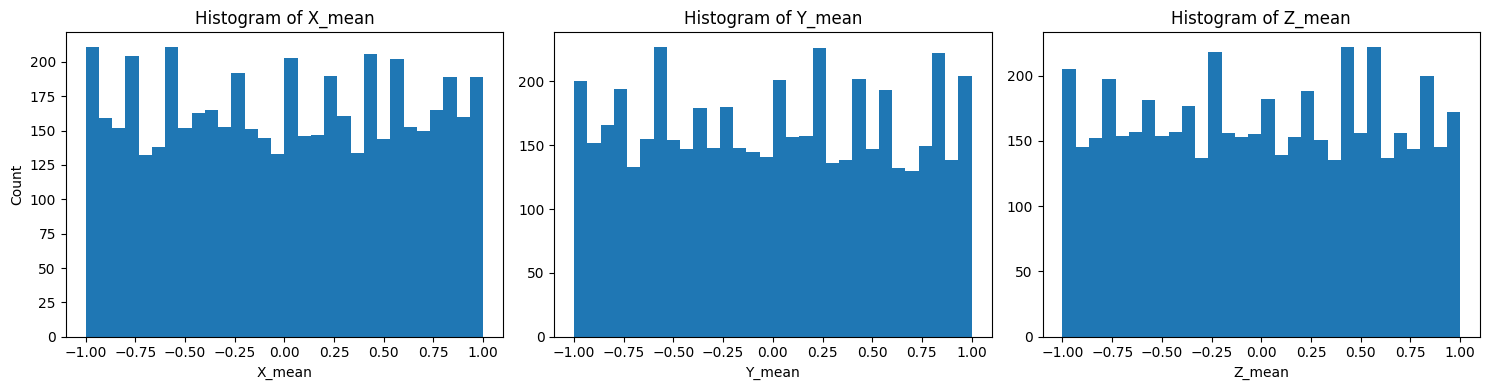

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["X_mean"], bins=30)
axes[0].set_title("Histogram of X_mean")
axes[0].set_xlabel("X_mean")
axes[0].set_ylabel("Count")

axes[1].hist(df["Y_mean"], bins=30)
axes[1].set_title("Histogram of Y_mean")
axes[1].set_xlabel("Y_mean")

axes[2].hist(df["Z_mean"], bins=30)
axes[2].set_title("Histogram of Z_mean")
axes[2].set_xlabel("Z_mean")

plt.tight_layout()
plt.show()

As we can see, the X_mean, Y_mean and Z_mean are more or less uniformly distributed in our dataset. As we will apply the MLE algorithm, computing the mean fidelity of our predicted angles can give us a general idea about the overall estimation performance, no matter the initial vector of the Bloch sphere.

In [135]:
# Compute probabilities based on the mean
df["probaX+"] = (1 + df["X_mean"]) / 2.0
df["probaY+"] = (1 + df["Y_mean"]) / 2.0
df["probaZ+"] = (1 + df["Z_mean"]) / 2.0

# Compute number of occurence of each state
# ! We take N_SHOTS = 100 as established before (dataset creation)
df["numberX"] = (df["probaX+"] * N_SHOTS).round().astype(int)
df["numberY"] = (df["probaY+"] * N_SHOTS).round().astype(int)
df["numberZ"] = (df["probaZ+"] * N_SHOTS).round().astype(int)

df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,probaX+,probaY+,probaZ+,numberX,numberY,numberZ
0,0.92,-0.18,-0.28,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,0.96,0.41,0.36,96,41,36
1,-0.56,-0.58,0.06,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,0.22,0.21,0.53,22,21,53
2,-0.58,0.04,-0.68,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,0.21,0.52,0.16,21,52,16
3,-0.36,0.46,0.56,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,0.32,0.73,0.78,32,73,78
4,0.92,-0.06,-0.52,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,0.96,0.47,0.24,96,47,24


In [136]:
# General functions
def angles_from_bloch(nx, ny, nz):
    """
    Given Bloch vector (nx, ny, nz) on the sphere, return (theta, phi).
    """
    # First we normalize (just in case)
    norm = np.sqrt(nx ** 2 + ny ** 2 + nz ** 2)
    nx /= norm
    ny /= norm
    nz /= norm
    
    # Calculate theta and phi
    theta = np.arccos(nz)
    phi = np.arctan2(ny,nx)
    # Keep phi between 0 and 2pi
    phi = np.where(phi < 0, phi + 2*np.pi, phi)
    return theta, phi

def bloch_from_angles(theta, phi):
    """
    Given (theta, phi), return Bloch vector (nx, ny, nz).
    """
    # Just the normal formula to get the Bloch vector from the angles
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)
    return nx, ny, nz

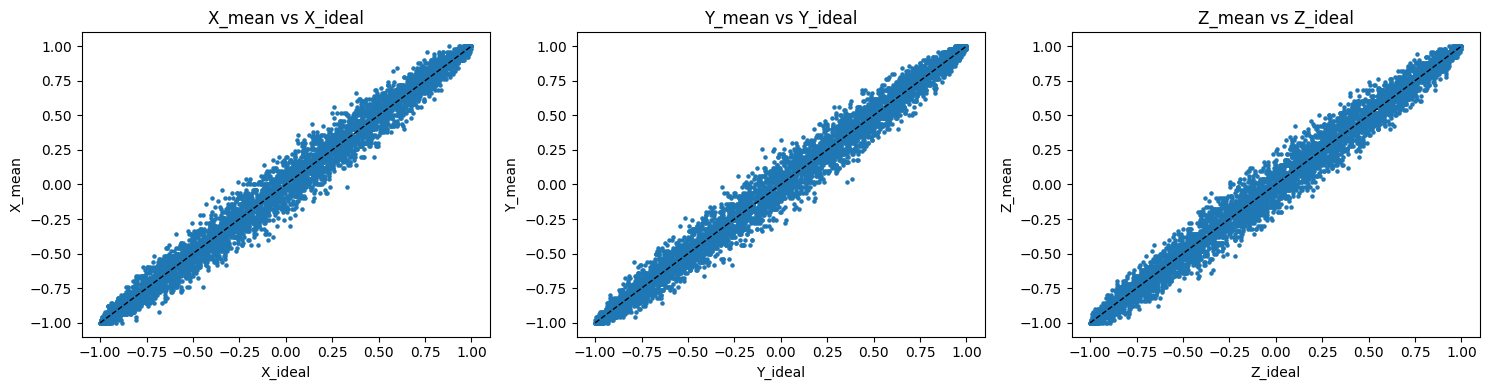

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df["X_ideal"], df["X_mean"], s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("X_mean vs X_ideal")
axes[0].set_xlabel("X_ideal")
axes[0].set_ylabel("X_mean")

axes[1].scatter(df["Y_ideal"], df["Y_mean"], s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("Y_mean vs Y_ideal")
axes[1].set_xlabel("Y_ideal")
axes[1].set_ylabel("Y_mean")

axes[2].scatter(df["Z_ideal"], df["Z_mean"], s=5)
axes[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[2].set_title("Z_mean vs Z_ideal")
axes[2].set_xlabel("Z_ideal")
axes[2].set_ylabel("Z_mean")

plt.tight_layout()
plt.show()

This graph shows us that the X_mean, Y_mean, Z_mean computed from the measurements (we simulated 200 measurement shots of a single state to estimate those parameters) is quite close to the expected means from our 1 qubit state.

In [138]:
# Adding some more information in our dataset
df["theta_measured"], df["phi_measured"] = angles_from_bloch(df["X_mean"].values
                                                             , df["Y_mean"].values
                                                             , df["Z_mean"].values)

# Compute the angle error of theta
df["theta_mes_error"] = np.abs(df["theta_measured"] - df["theta_ideal"])

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_mes_diff = (df["phi_measured"] - df["phi_ideal"] + np.pi) % (2.0 * np.pi) - np.pi
df["phi_mes_error"] = phi_mes_diff

df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,probaX+,probaY+,probaZ+,numberX,numberY,numberZ,theta_measured,phi_measured,theta_mes_error,phi_mes_error
0,0.940343,-0.183980,-0.286191,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,0.96,0.41,0.36,96,41,36,1.861046,6.089974,0.036619,0.116460
1,-0.692679,-0.717418,0.074216,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,0.22,0.21,0.53,22,21,53,1.496512,3.944533,0.007076,-0.060557
2,-0.648298,0.044710,-0.760073,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,0.21,0.52,0.16,21,52,16,2.434222,3.072736,0.002067,0.177578
3,-0.444885,0.568465,0.692044,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,0.32,0.73,0.78,32,73,78,0.806480,2.234842,0.076454,0.087141
4,0.869163,-0.056685,-0.491266,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,0.96,0.47,0.24,96,47,24,2.084339,6.218060,0.043699,-0.047058


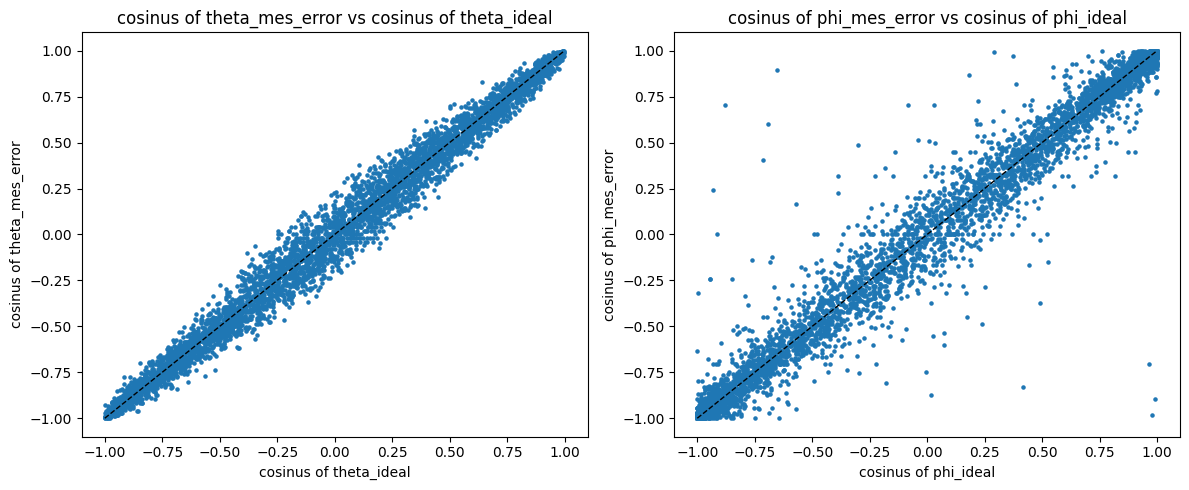

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# theta
axes[0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_measured"]), s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("cosinus of theta_mes_error vs cosinus of theta_ideal")
axes[0].set_xlabel("cosinus of theta_ideal")
axes[0].set_ylabel("cosinus of theta_mes_error")

# phi
axes[1].scatter(df["cos_phi_ideal"], np.cos(df["phi_measured"]), s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("cosinus of phi_mes_error vs cosinus of phi_ideal")
axes[1].set_xlabel("cosinus of phi_ideal")
axes[1].set_ylabel("cosinus of phi_mes_error")

plt.tight_layout()
plt.show()

The left graph shows how off is the theta angle from the measurement with the actual theta angle of the system. The points fall very close to the black diagonal, showing that the estimated values match the true values with already good accuracy. The measurement is quite accurate and stable.

On the other hand, the right graph is much more noisier and the phi angle measured may be way off compared to the actual phi angle. But as we estimated a total of 5000 values, only a few points seem to be way off the diagonal which represent perfectly measured angle, so the majority of the phi angles are still estimated with a good precision.

We will see in the next section the metrics to show how off the measurements are from the actual state of our qubit.

**Metrics:**

In [140]:
nx_true, ny_true, nz_true = bloch_from_angles(df["theta_ideal"], df["phi_ideal"])
nx_mes, ny_mes, nz_mes = bloch_from_angles(df["theta_measured"].values, df["phi_measured"].values)

# Computing fidelity according to the formula
dot_prod_mes = nx_true * nx_mes + ny_true * ny_mes + nz_true * nz_mes
df["fidelity_mes"] = np.abs(dot_prod_mes) ** 2
d_mes = np.arccos(dot_prod_mes).mean()

bias_theta_mes = df["theta_measured"].mean() - df["theta_ideal"].mean()
var_theta_mes = df["theta_mes_error"].var(ddof=0) 
mse_theta_mes = ((df["theta_measured"] - df["theta_ideal"]) ** 2).mean()
rmse_theta_mes = np.sqrt(mse_theta_mes)

print("Mean measured fidelity:", np.mean(df["fidelity_mes"]))
print("Mean distance on the sphere between the actual vector and measured vector: ", d_mes, "\n")

print("Theta (based on measurements):")
print("Bias:                          ", bias_theta_mes)
print("Variance:                      ", var_theta_mes)
print("Mean square error (MSE):       ", mse_theta_mes)
print("Mean absolute error (MAE):     ", np.mean(df["theta_mes_error"]))
print("Root mean square error (RMSE): ", rmse_theta_mes, "\n")

print("Phi (based on measurements):")
# À COMPLETER POUR PHI


Mean measured fidelity: 0.9841177243001623
Mean distance on the sphere between the actual vector and measured vector:  0.11191120440746197 

Theta (based on measurements):
Bias:                           -0.00026638876267770506
Variance:                       0.002790616024018015
Mean square error (MSE):        0.007463309613209313
Mean absolute error (MAE):      0.06835710342891438
Root mean square error (RMSE):  0.08639044862257235 

Phi (based on measurements):


### 1.2. Applying the algorithm

Now we will apply the MLE algorithm.

In [141]:
# Functions for the MLE algorithm
def neg_log_likelihood(params, row):
    theta, phi = params # Parameters to optimize
    
    # Get the components of the estimated Bloch vector based on theta and phi (variables)
    nx, ny, nz = bloch_from_angles(theta, phi) 
    
    # New estimated probabilities 
    px_plus = (1.0 + nx) / 2.0
    py_plus = (1.0 + ny) / 2.0
    pz_plus = (1.0 + nz) / 2.0
    
    # Just to be sure to avoid log(0)
    eps = 1e-12
    px_plus = np.clip(px_plus, eps, 1.0 - eps)
    py_plus = np.clip(py_plus, eps, 1.0 - eps)
    pz_plus = np.clip(pz_plus, eps, 1.0 - eps)
    
    # Negative log likelihood formula
    nllx = -(df.iloc[row]["numberX"] * np.log(px_plus) + 
             (N_SHOTS - df.iloc[row]["numberX"]) * np.log(1 - px_plus))
    nlly = -(df.iloc[row]["numberY"] * np.log(py_plus) + 
             (N_SHOTS - df.iloc[row]["numberY"]) * np.log(1 - py_plus))
    nllz = -(df.iloc[row]["numberZ"] * np.log(pz_plus) + 
             (N_SHOTS - df.iloc[row]["numberZ"]) * np.log(1 - pz_plus))
    
    return nllx + nlly + nllz

def mle_row(row):
    # First estimation of theta and phi (based on the mean)
    theta0, phi0 = angles_from_bloch(df.iloc[row]["X_mean"], df.iloc[row]["Y_mean"], df.iloc[row]["Z_mean"])
    
    # Keep theta between 0 and pi and phi between 0 and 2pi
    bounds = [(0.0, np.pi), (0.0, 2.0 * np.pi)]
    
    # Minimize the Negative Log Likelihood
    res = minimize(
        fun=neg_log_likelihood,
        x0=np.array([theta0, phi0], dtype=float),
        args=(row,),
        bounds=bounds,
        method="L-BFGS-B"
    )
    
    theta_hat, phi_hat = res.x
    # In case phi = 2pi we bring it back to 0
    phi_hat = phi_hat % (2.0 * np.pi)
    
    return theta_hat, phi_hat

df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,...,probaY+,probaZ+,numberX,numberY,numberZ,theta_measured,phi_measured,theta_mes_error,phi_mes_error,fidelity_mes
0,0.940343,-0.183980,-0.286191,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,...,0.41,0.36,96,41,36,1.861046,6.089974,0.036619,0.116460,0.986142
1,-0.692679,-0.717418,0.074216,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,...,0.21,0.53,22,21,53,1.496512,3.944533,0.007076,-0.060557,0.996309
2,-0.648298,0.044710,-0.760073,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,...,0.52,0.16,21,52,16,2.434222,3.072736,0.002067,0.177578,0.986727
3,-0.444885,0.568465,0.692044,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,...,0.73,0.78,32,73,78,0.806480,2.234842,0.076454,0.087141,0.989951
4,0.869163,-0.056685,-0.491266,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,...,0.47,0.24,96,47,24,2.084339,6.218060,0.043699,-0.047058,0.996374


In [142]:
theta_hats = []
phi_hats = []

# Apply the algorithm to every state. It takes around 1 minute to run
for i in range(len(df)):
    theta_hat, phi_hat = mle_row(i)
    theta_hats.append(theta_hat)
    phi_hats.append(phi_hat)

In [143]:
df["theta_hat"] = theta_hats
df["phi_hat"] = phi_hats

df["X_predicted"], df["Y_predicted"], df["Z_predicted"] = bloch_from_angles(df["theta_hat"], df["phi_hat"])
df["probaX+_pred"] = (1 + df["X_predicted"]) / 2.0
df["probaY+_pred"] = (1 + df["Y_predicted"]) / 2.0
df["probaZ+_pred"] = (1 + df["Z_predicted"]) / 2.0

theta_true = df["theta_ideal"].values
phi_true = df["phi_ideal"].values

theta_hat_arr = df["theta_hat"].values
phi_hat_arr = df["phi_hat"].values

# Compute the angle error of theta
df["theta_error"] = np.abs(theta_hat_arr - theta_true)

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_diff = (phi_hat_arr - phi_true + np.pi) % (2.0 * np.pi) - np.pi
df["phi_error"] = phi_diff

nx_hat, ny_hat, nz_hat = bloch_from_angles(theta_hat_arr, phi_hat_arr)

# Computing fidelity according to the formula
dot_prod = nx_true * nx_hat + ny_true * ny_hat + nz_true * nz_hat
df["fidelity"] = np.abs(dot_prod) ** 2

# Computing MLL (Mean log likelihood)
df["Mean_ll"] = (df["numberX"] * np.log(df["probaX+_pred"]) + 
                 (N_SHOTS - df["numberX"]) * np.log(1.0 - df["probaX+_pred"]) + 
                 df["numberY"] * np.log(df["probaY+_pred"]) + 
                 (N_SHOTS - df["numberY"]) * np.log(1.0 - df["probaY+_pred"]) + 
                 df["numberZ"] * np.log(df["probaZ+_pred"]) + 
                 (N_SHOTS - df["numberZ"]) * np.log(1.0 - df["probaZ+_pred"])) / N_SHOTS

# Cross entropy, KL divergence, Fisher information à ajouter
# ajouter colonnes pour l'erreur entre les valeurs mesurées et réelles

mean_logL_per_shot = df["Mean_ll"].sum() / TOTAL_SHOTS
mean_logL_per_state =df["Mean_ll"].mean()

print("Mean log-likelihood per shot   :", mean_logL_per_shot)
print("Mean log-likelihood per state  :", mean_logL_per_state)

print("Mean |theta_error|:", np.mean(df["theta_error"]))
print("Mean |phi_error|  :", np.mean(np.abs(df["phi_error"])))
print("Mean fidelity     :", np.mean(df["fidelity"]))

df.to_csv("results_mle.csv", index=False)

df.head()

Mean log-likelihood per shot   : -24.78586508937556
Mean log-likelihood per state  : -1.4871519053625335
Mean |theta_error|: 0.06417528557175207
Mean |phi_error|  : 0.11187032524956199
Mean fidelity     : 0.9852189486588115


,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,...,X_predicted,Y_predicted,Z_predicted,probaX+_pred,probaY+_pred,probaZ+_pred,theta_error,phi_error,fidelity,Mean_ll
0,0.940343,-0.183980,-0.286191,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,...,0.931420,-0.197574,-0.305648,0.965710,0.401213,0.347176,0.056989,0.100648,0.987464,-1.499210
1,-0.692679,-0.717418,0.074216,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,...,-0.695355,-0.712258,0.095760,0.152323,0.143871,0.547880,0.014547,-0.066092,0.995461,-1.764745
2,-0.648298,0.044710,-0.760073,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,...,-0.659491,0.050810,-0.749993,0.170254,0.525405,0.125004,0.013307,0.169541,0.987507,-1.656521
3,-0.444885,0.568465,0.692044,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,...,-0.469278,0.574940,0.670240,0.265361,0.787470,0.835120,0.046670,0.107649,0.991204,-1.763887
4,0.869163,-0.056685,-0.491266,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,...,0.887604,-0.051213,-0.457752,0.943802,0.474394,0.271124,0.005622,-0.039567,0.998728,-1.415659


As we can see, the MLE estimation works very well as it can estimate with more than 99% fidelity the angles theta and phi from our 1 qubit state. It also shows very small errors of angle estimation for theta and phi.

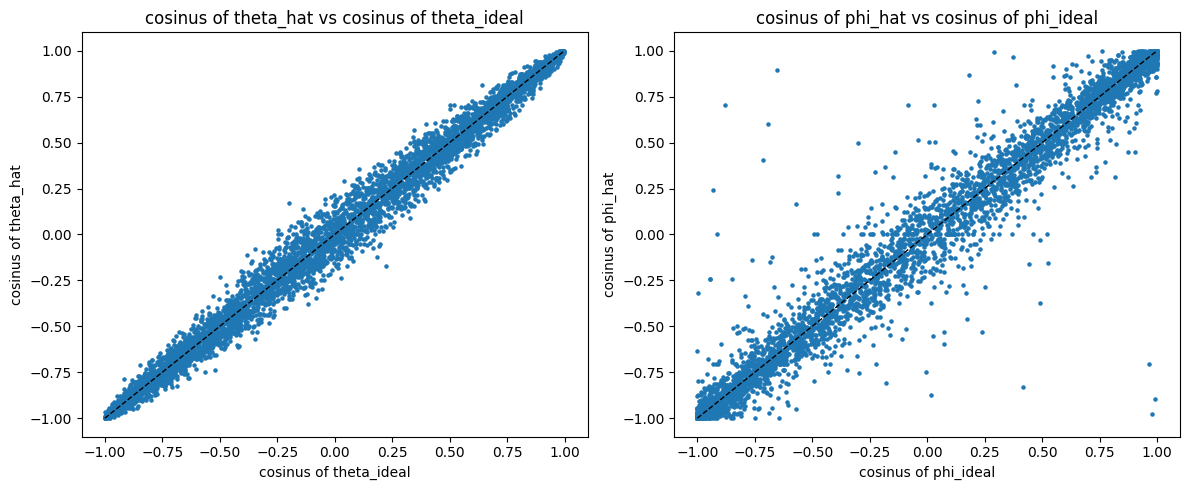

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# theta
axes[0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_hat"]), s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("cosinus of theta_hat vs cosinus of theta_ideal")
axes[0].set_xlabel("cosinus of theta_ideal")
axes[0].set_ylabel("cosinus of theta_hat")

# phi
axes[1].scatter(df["cos_phi_ideal"], np.cos(df["phi_hat"]), s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("cosinus of phi_hat vs cosinus of phi_ideal")
axes[1].set_xlabel("cosinus of phi_ideal")
axes[1].set_ylabel("cosinus of phi_hat")

plt.tight_layout()
plt.show()

The left graph shows how well the theta angle was estimated with MLE. The points fall very close to the black diagonal, showing that the estimated values match the true values almost perfectly. The estimation is very accurate and stable.

On the other hand, the right graph is a little bit noisier and the estimation of the phi angle estimation is not as good as the theta estimation. As we estimated a total of 5000 values, only a few scattered points represent no big deal ; most of the estimated values are still very close to the original ones.

This difference between the two graphs can be easily explained: this is due to the probabilistic uncertainty of our model. We computed 200 measurements of each state, meaning each mean was computed with 200 values. The theta angle comes directly from the ⟨Z​⟩ expectation value, as we have θ = arccos(Z). The precision of theta is directly linked to the precision of Z_mean. On the other hand, phi is obtained with ϕ = arctan(Y​,X​), so the precision of phi depends on both ⟨X⟩ and ⟨Y⟩.

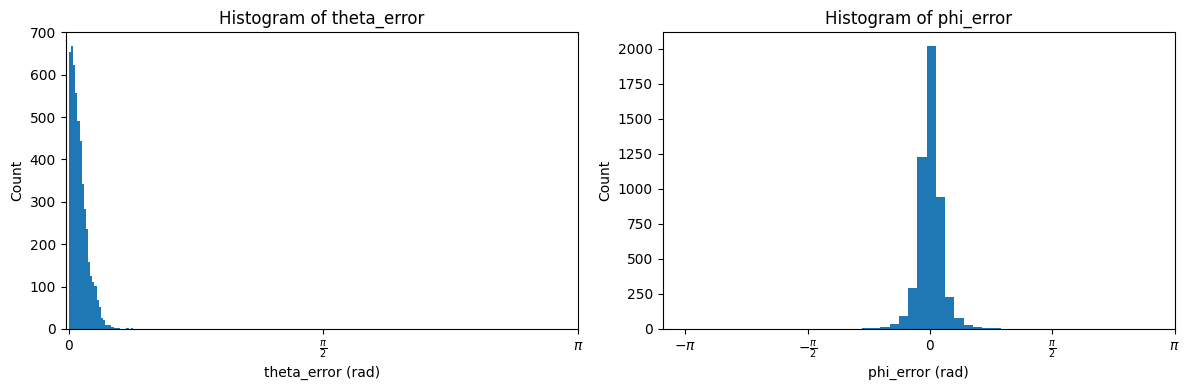

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["theta_error"], bins=30)
axes[0].set_title("Histogram of theta_error")
axes[0].set_xlabel("theta_error (rad)")
axes[0].set_ylabel("Count")

ticks = [0, np.pi/2, np.pi]
labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels)

axes[1].hist(df["phi_error"], bins=50)
axes[1].set_title("Histogram of phi_error")
axes[1].set_xlabel("phi_error (rad)")
axes[1].set_ylabel("Count")

ticks_phi = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
labels_phi = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

axes[1].set_xticks(ticks_phi)
axes[1].set_xticklabels(labels_phi)

plt.tight_layout()
plt.show()


Here, we can see the plot of the angle error for both theta and phi. The error is for both cases around 0 and decreases as it gets farther. 

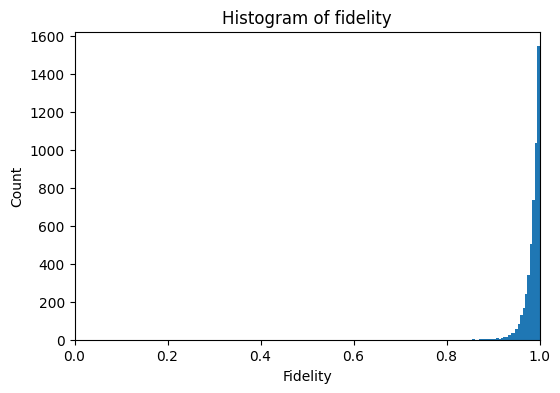

In [146]:
plt.figure(figsize=(6, 4))
plt.hist(df["fidelity"], bins=30)
plt.title("Histogram of fidelity")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.xlim(0, 1)

plt.show()


This is the fidelity of every predicted state, and as we can see every state is very close to one.

In [147]:
df["phi_error_abs"] = np.abs(df["phi_error"])
corr = df.corr(numeric_only=True)   # Correlations
corr_phi = corr["phi_error_abs"].sort_values(ascending=False)
print(corr_phi)


phi_error_abs      1.000000
Mean_ll            0.063025
phi_ideal          0.016257
Y_predicted        0.009689
probaY+_pred       0.009689
Y_mean             0.009055
probaY+            0.008463
numberY            0.008463
theta_ideal        0.004195
Y_ideal            0.004190
theta_measured     0.003667
theta_hat          0.003329
X_ideal            0.000876
probaX+            0.000195
numberX            0.000195
X_mean             0.000052
X_predicted       -0.001386
probaX+_pred      -0.001386
Z_predicted       -0.002812
probaZ+_pred      -0.002812
Z_ideal           -0.002968
Z_mean            -0.003099
numberZ           -0.003869
probaZ+           -0.003869
sin_phi_ideal     -0.005106
cos_phi_ideal     -0.009546
theta_mes_error   -0.020845
phi_measured      -0.021922
phi_hat           -0.022024
theta_error       -0.052712
phi_mes_error     -0.063263
phi_error         -0.064575
fidelity_mes      -0.394012
fidelity          -0.425122
Name: phi_error_abs, dtype: float64


## General metrics

Here are some general metrics of the algorithm to judge the pertinance of our model:

In [148]:
bias_theta = df["theta_hat"].mean() - df["theta_ideal"].mean()
var_theta = df["theta_error"].var(ddof=0) 
mse_theta = ((df["theta_hat"] - df["theta_ideal"]) ** 2).mean()
rmse_theta = np.sqrt(mse_theta)

d = np.arccos(dot_prod).mean()

print("Mean |theta_error|:", np.mean(np.abs(df["theta_error"])))
print("Mean |phi_error|  :", np.mean(np.abs(df["phi_error"])))
print("Mean fidelity     :", np.mean(df["fidelity"]))

print("Theta:")
print("Bias:", bias_theta)
print("Variance:", var_theta)
print("Mean square error (MSE): ", mse_theta)
print("Mean absolute error (MAE): ", np.mean(df["theta_error"]))
print("Root mean square error (RMSE): ", rmse_theta)
print("Distance on the sphere: ", d)

Mean |theta_error|: 0.06417528557175207
Mean |phi_error|  : 0.11187032524956199
Mean fidelity     : 0.9852189486588115
Theta:
Bias: 0.00029873857896789424
Variance: 0.0025530381042584067
Mean square error (MSE):  0.006671505382474336
Mean absolute error (MAE):  0.06417528557175207
Root mean square error (RMSE):  0.08167928367997809
Distance on the sphere:  0.1073346305248401


In [149]:
df_sorted = df.sort_values(by="fidelity", ascending=True)
df_sorted.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,...,Y_predicted,Z_predicted,probaX+_pred,probaY+_pred,probaZ+_pred,theta_error,phi_error,fidelity,Mean_ll,phi_error_abs
1310,0.995950,0.063571,0.063571,1.496965,6.050396,0.973027,-0.230692,0.970376,-0.230064,0.073764,...,1.624249e-01,0.162425,0.986630,0.581212,0.581213,0.089317,0.398152,0.844638,-1.535864,0.398152
1559,-0.999783,0.000000,-0.020829,1.346003,3.109178,-0.999475,0.032409,-0.974328,0.031594,0.222905,...,2.975339e-07,-0.169135,0.007204,0.500000,0.415432,0.394746,0.032414,0.851172,-1.503139,0.032414
2956,0.677349,-0.019353,-0.735407,2.118978,5.903702,0.928856,-0.370441,0.792754,-0.316161,-0.521137,...,-1.873852e-02,-0.737341,0.837630,0.490631,0.131330,0.280944,0.351741,0.856542,-1.483733,0.351741
4936,-0.766356,0.020712,-0.642082,2.381033,2.597021,-0.855349,0.518052,-0.589615,0.357107,-0.724451,...,2.151962e-02,-0.646578,0.118728,0.510760,0.176711,0.107147,0.516359,0.856932,-1.566745,0.516359
4383,0.000000,-0.999783,0.020829,1.768939,4.649031,-0.063316,-0.997994,-0.062077,-0.978467,-0.196849,...,-9.855928e-01,0.169135,0.500000,0.007204,0.584568,0.368095,0.063358,0.866902,-1.503139,0.063358


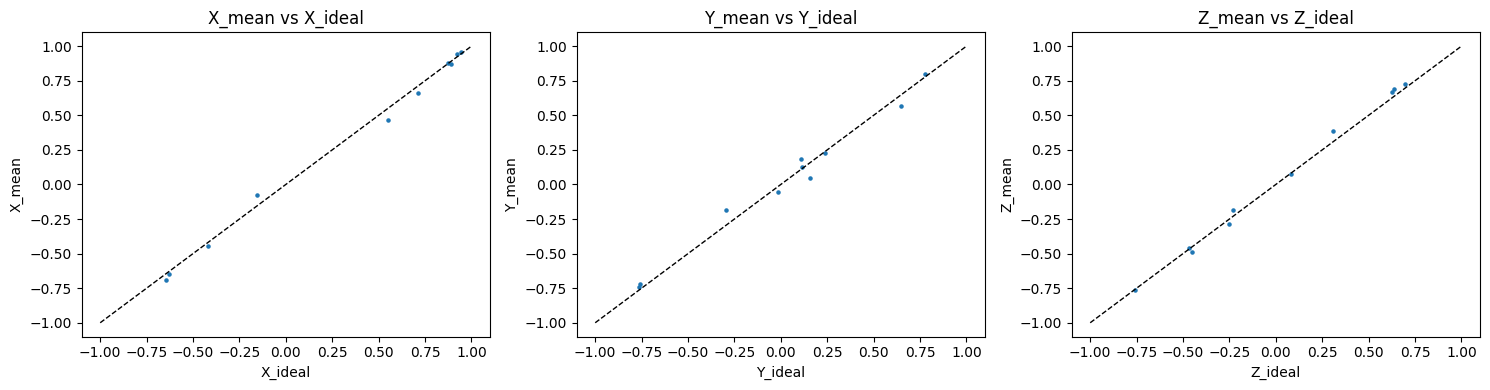

In [150]:
df_head100 = df.head(10)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df_head100["X_ideal"], df_head100["X_mean"], s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("X_mean vs X_ideal")
axes[0].set_xlabel("X_ideal")
axes[0].set_ylabel("X_mean")

axes[1].scatter(df_head100["Y_ideal"], df_head100["Y_mean"], s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("Y_mean vs Y_ideal")
axes[1].set_xlabel("Y_ideal")
axes[1].set_ylabel("Y_mean")

axes[2].scatter(df_head100["Z_ideal"], df_head100["Z_mean"], s=5)
axes[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[2].set_title("Z_mean vs Z_ideal")
axes[2].set_xlabel("Z_ideal")
axes[2].set_ylabel("Z_mean")

plt.tight_layout()
plt.show()

In [151]:
corr_fid = corr["fidelity"].sort_values(ascending=False)
print(corr_fid)

fidelity           1.000000
fidelity_mes       0.916255
Mean_ll            0.029530
theta_hat          0.012107
theta_measured     0.011690
theta_ideal        0.010389
phi_error          0.004813
phi_mes_error      0.004770
probaX+_pred      -0.002225
X_predicted       -0.002225
numberX           -0.003382
probaX+           -0.003382
X_mean            -0.003786
X_ideal           -0.004589
cos_phi_ideal     -0.005012
phi_ideal         -0.005113
Z_ideal           -0.010512
probaZ+           -0.011235
numberZ           -0.011235
phi_hat           -0.011511
phi_measured      -0.011516
Z_mean            -0.012524
Z_predicted       -0.012712
probaZ+_pred      -0.012712
Y_ideal           -0.013912
sin_phi_ideal     -0.014215
numberY           -0.015860
probaY+           -0.015860
Y_mean            -0.017287
Y_predicted       -0.018180
probaY+_pred      -0.018180
phi_error_abs     -0.425122
theta_mes_error   -0.507304
theta_error       -0.574322
Name: fidelity, dtype: float64
